# Environment

---



## Prepare the data

---



In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meshadelbadran","key":"37b1a39cebd51d3491d8bbf17150011e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zaynena/selfdriving-car-simulator

Dataset URL: https://www.kaggle.com/datasets/zaynena/selfdriving-car-simulator
License(s): copyright-authors
100% 2.24G/2.24G [00:21<00:00, 197MB/s]
100% 2.24G/2.24G [00:21<00:00, 110MB/s]


In [ ]:
!unzip selfdriving-car-simulator.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_348.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_416.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_483.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_555.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_623.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_695.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_764.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_833.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_907.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_14_979.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_15_048.jpg  
  inflating: data/track2data/track2data/IMG/right_2019_04_02_18_25_15

## Prepare the libraries

---



In [ ]:
import os
import random
import warnings
from typing import Tuple
from tqdm import tqdm

import cv2
import ntpath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# Suppress warnings
warnings.filterwarnings("ignore")


# Data Processing

---



## Data understanding

---



### 📦 **About Dataset**

#### **Context**
This is an image dataset generated by the **Udacity Self-Driving Car Simulator**.  
The dataset contains driving images from cameras mounted on a virtual vehicle and corresponding driving parameters such as steering angle, throttle, brake, and speed.

---

### 📁 **Dataset Structure**

| Folder | Description | Size
|--------|-------------|------
| **track1data/** | Contains images and CSV log file collected only from Track 1 | 31,845
| **track2data/** | Contains images and CSV log file collected only from Track 2 | 65,484
| **dataset/** | Contains all images from both **track1data/** and **track2data/** combined | 97,329

---

### 📄 **CSV File Columns**

| Column | Meaning |
|--------|---------|
| **Center** | Center camera image path |
| **Left** | Left camera image path |
| **Right** | Right camera image path |
| **Steering** | Steering wheel angle |
| **Throttle** | Throttle value (acceleration) |
| **Brake** | Brake value |
| **Speed** | Vehicle speed |

---


|index|Steering|Throttle|Brake|Speed|
|---|---|---|---|---|
|count|21828\.0|21828\.0|21828\.0|21828\.0|
|mean|-0\.01318031883818948|0\.20500802925959638|0\.028569632292197635|8\.782329734606764|
|std|0\.46189122305571556|0\.28688580517629336|0\.1198930944174388|2\.7422589671476296|
|min|-1\.0|0\.0|0\.0|1\.835208e-05|
|25%|-0\.1|0\.0|0\.0|7\.1821675|
|50%|0\.0|0\.0|0\.0|8\.93185|
|75%|0\.05|0\.3538586|0\.0|10\.4863525|
|max|1\.0|1\.0|1\.0|19\.29511|

| Steering Value      | Direction     |
|---------------------|---------------|
| Less than 0 (`< 0`) | Turn **Right**|
| Greater than 0 (`> 0`) | Turn **Left** |


## Data loading

---



In [ ]:
# Path to driving log file
CSV_PATH = "/content/data/track2data/track2data/driving_log.csv"


In [ ]:
# Driving log columns
COLUMNS = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']

# Load dataset
data = pd.read_csv(CSV_PATH, names=COLUMNS)

# Preview data
data.sample(100)


,Center,Left,Right,Steering,Throttle,Brake,Speed
7400,Desktop\track2data\IMG\center_2019_04_02_18_14...,Desktop\track2data\IMG\left_2019_04_02_18_14_1...,Desktop\track2data\IMG\right_2019_04_02_18_14_...,0.30,0.183048,0.0,8.558304
6894,Desktop\track2data\IMG\center_2019_04_02_18_13...,Desktop\track2data\IMG\left_2019_04_02_18_13_4...,Desktop\track2data\IMG\right_2019_04_02_18_13_...,0.00,0.000000,0.0,0.002404
14466,Desktop\track2data\IMG\center_2019_04_02_18_22...,Desktop\track2data\IMG\left_2019_04_02_18_22_2...,Desktop\track2data\IMG\right_2019_04_02_18_22_...,0.00,0.100739,0.0,9.578149
10723,Desktop\track2data\IMG\center_2019_04_02_18_18...,Desktop\track2data\IMG\left_2019_04_02_18_18_0...,Desktop\track2data\IMG\right_2019_04_02_18_18_...,0.00,0.295689,0.0,13.013240
14468,Desktop\track2data\IMG\center_2019_04_02_18_22...,Desktop\track2data\IMG\left_2019_04_02_18_22_2...,Desktop\track2data\IMG\right_2019_04_02_18_22_...,0.00,0.000000,0.0,9.462029
...,...,...,...,...,...,...,...
5638,Desktop\track2data\IMG\center_2019_04_02_18_12...,Desktop\track2data\IMG\left_2019_04_02_18_12_1...,Desktop\track2data\IMG\right_2019_04_02_18_12_...,0.00,0.100432,0.0,14.671910
8885,Desktop\track2data\IMG\center_2019_04_02_18_15...,Desktop\track2data\IMG\left_2019_04_02_18_15_5...,Desktop\track2data\IMG\right_2019_04_02_18_15_...,0.00,0.247406,0.0,7.898227
3658,Desktop\track2data\IMG\center_2019_04_02_18_09...,Desktop\track2data\IMG\left_2019_04_02_18_09_5...,Desktop\track2data\IMG\right_2019_04_02_18_09_...,-1.00,0.642817,0.0,11.175830
8394,Desktop\track2data\IMG\center_2019_04_02_18_15...,Desktop\track2data\IMG\left_2019_04_02_18_15_2...,Desktop\track2data\IMG\right_2019_04_02_18_15_...,-0.05,0.161571,0.0,10.129300


In [ ]:
# Show basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21828 entries, 0 to 21827
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Center    21828 non-null  object 
 1   Left      21828 non-null  object 
 2   Right     21828 non-null  object 
 3   Steering  21828 non-null  float64
 4   Throttle  21828 non-null  float64
 5   Brake     21828 non-null  float64
 6   Speed     21828 non-null  float64
dtypes: float64(4), object(3)
memory usage: 1.2+ MB


In [ ]:
# Show basic statistical summary of the data
data.describe()

,Steering,Throttle,Brake,Speed
count,21828.000000,21828.000000,21828.000000,21828.000000
mean,-0.013180,0.205008,0.028570,8.782330
std,0.461891,0.286886,0.119893,2.742259
min,-1.000000,0.000000,0.000000,0.000018
25%,-0.100000,0.000000,0.000000,7.182168
50%,0.000000,0.000000,0.000000,8.931850
75%,0.050000,0.353859,0.000000,10.486353
max,1.000000,1.000000,1.000000,19.295110


In [ ]:
# Normalize image paths (convert Windows slashes to Unix)
def normalize_path(p: str) -> str:
    return p.replace("\\", "/")

# Apply normalization
for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(normalize_path)


In [ ]:
def get_filename(path: str) -> str:
    """Return filename from full path."""
    return ntpath.basename(path)

# Extract filenames
for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(get_filename)

# Preview data
data.sample(100)

,Center,Left,Right,Steering,Throttle,Brake,Speed
15296,center_2019_04_02_18_23_27_420.jpg,left_2019_04_02_18_23_27_420.jpg,right_2019_04_02_18_23_27_420.jpg,-0.30,0.085095,0.0,5.490876
15901,center_2019_04_02_18_24_09_462.jpg,left_2019_04_02_18_24_09_462.jpg,right_2019_04_02_18_24_09_462.jpg,0.70,0.000000,0.0,15.236450
19734,center_2019_04_02_18_28_38_087.jpg,left_2019_04_02_18_28_38_087.jpg,right_2019_04_02_18_28_38_087.jpg,0.35,0.259676,0.0,8.793301
11466,center_2019_04_02_18_18_59_536.jpg,left_2019_04_02_18_18_59_536.jpg,right_2019_04_02_18_18_59_536.jpg,0.70,0.000000,0.0,7.904655
5880,center_2019_04_02_18_12_28_606.jpg,left_2019_04_02_18_12_28_606.jpg,right_2019_04_02_18_12_28_606.jpg,0.00,0.000000,0.0,13.428010
...,...,...,...,...,...,...,...
15926,center_2019_04_02_18_24_11_231.jpg,left_2019_04_02_18_24_11_231.jpg,right_2019_04_02_18_24_11_231.jpg,0.00,0.000000,0.0,13.460600
11896,center_2019_04_02_18_19_29_937.jpg,left_2019_04_02_18_19_29_937.jpg,right_2019_04_02_18_19_29_937.jpg,-1.00,0.742592,0.0,8.853215
12283,center_2019_04_02_18_19_57_123.jpg,left_2019_04_02_18_19_57_123.jpg,right_2019_04_02_18_19_57_123.jpg,0.00,0.500443,0.0,9.201361
19439,center_2019_04_02_18_28_17_512.jpg,left_2019_04_02_18_28_17_512.jpg,right_2019_04_02_18_28_17_512.jpg,0.00,0.000000,0.0,12.961200


## Data balancing

---



In [ ]:
# Steering distribution parameters
NUM_BINS = 25
SAMPLES_PER_BIN = 1600  # Hyperparameter

# Steering histogram
hist, bins = np.histogram(data["Steering"], bins=NUM_BINS)
print("Bin edges:", bins)


Bin edges: [-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


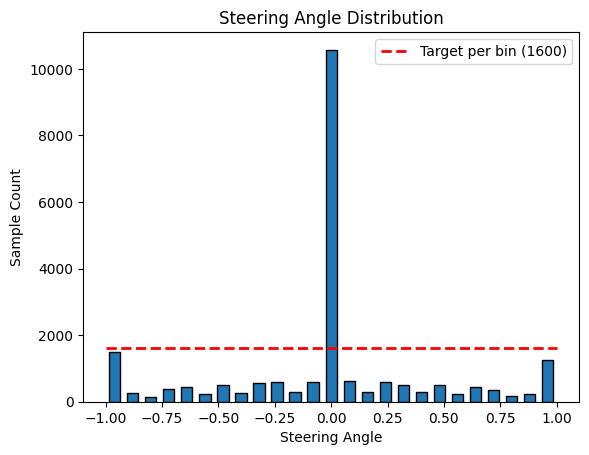

In [ ]:
# Bin centers
centers = (bins[:-1] + bins[1:]) / 2

# Plot steering distribution
plt.bar(centers, hist, width=0.05, edgecolor='k')
plt.plot(
    [data["Steering"].min(), data["Steering"].max()],
    [SAMPLES_PER_BIN, SAMPLES_PER_BIN],
    "r--",
    linewidth=2,
    label=f"Target per bin ({SAMPLES_PER_BIN})"
)

plt.title("Steering Angle Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")
plt.legend()
plt.show()

In [ ]:
print(f"Total samples: {len(data)}")

Total samples: 21828


In [ ]:
remove_list = []
steering_vals = data["Steering"].values

for i in range(NUM_BINS):
    if i < NUM_BINS - 1:
        mask = (steering_vals >= bins[i]) & (steering_vals < bins[i + 1])
    else:
        mask = (steering_vals >= bins[i]) & (steering_vals <= bins[i + 1])

    indices = np.where(mask)[0]
    np.random.shuffle(indices)
    remove_list.extend(indices[SAMPLES_PER_BIN:])


In [ ]:
# Balance dataset by dropping excess samples
data_balanced = data.drop(remove_list)
print(f"Samples retained: {len(data_balanced)}")

Samples retained: 12853


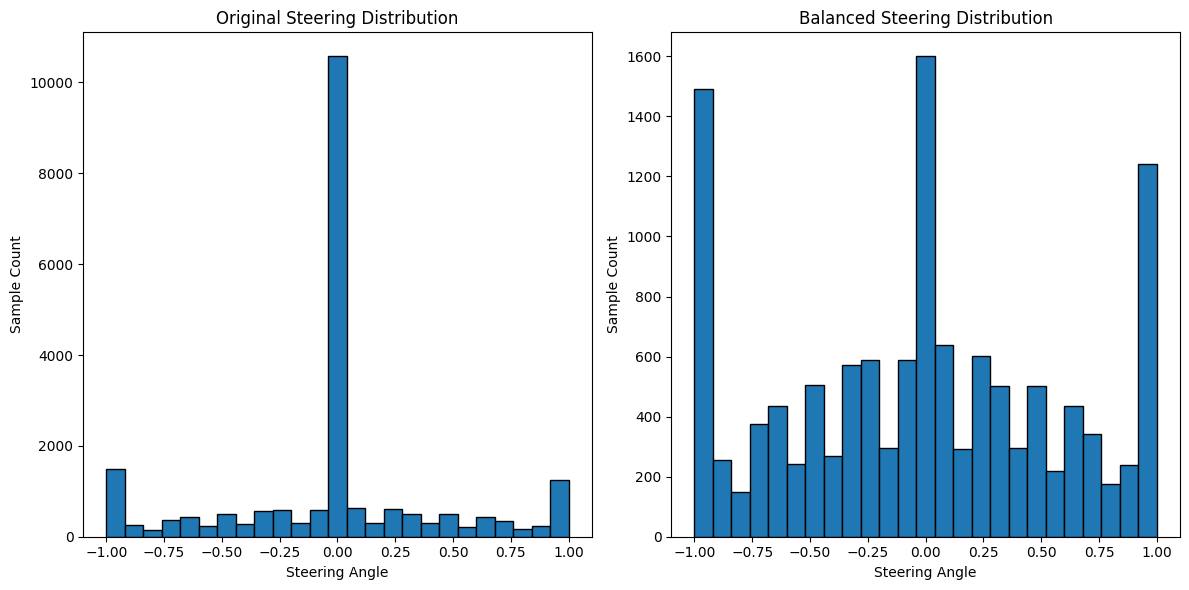

In [ ]:
plt.figure(figsize=(12, 6))

# Original distribution
plt.subplot(1, 2, 1)
plt.hist(data["Steering"], bins=NUM_BINS, edgecolor="k")
plt.title("Original Steering Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")

# Balanced distribution
plt.subplot(1, 2, 2)
plt.hist(data_balanced["Steering"], bins=NUM_BINS, edgecolor="k")
plt.title("Balanced Steering Distribution")
plt.xlabel("Steering Angle")
plt.ylabel("Sample Count")

plt.tight_layout()
plt.show()

## Data splitting

---



In [ ]:
DATA_DIR = '/content/data/track2data/track2data/IMG'

In [ ]:
def load_images_and_steering(data_dir: str, df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """Load image paths and steering angles with side camera corrections."""
    image_paths, steerings = [], []

    correction = 0.15
    for _, row in df.iterrows():
        center, left, right = row['Center'], row['Left'], row['Right']
        steer = float(row['Steering'])

        image_paths.extend([
            os.path.join(data_dir, center),
            os.path.join(data_dir, left),
            os.path.join(data_dir, right),
        ])
        steerings.extend([
            steer,
            steer  + correction,
            steer - correction,
        ])

    return np.array(image_paths), np.array(steerings)

# Usage
image_paths, steerings = load_images_and_steering(DATA_DIR + '/', data)

In [ ]:
def fix_path(path: str) -> str:
    return path.replace("\\", "/")

for col in ["Center", "Left", "Right"]:
    data[col] = data[col].apply(fix_path)

In [ ]:
# Preview data
data.sample(100)

,Center,Left,Right,Steering,Throttle,Brake,Speed
9872,center_2019_04_02_18_17_08_259.jpg,left_2019_04_02_18_17_08_259.jpg,right_2019_04_02_18_17_08_259.jpg,0.45,0.000000,0.329629,10.318900
16698,center_2019_04_02_18_25_05_318.jpg,left_2019_04_02_18_25_05_318.jpg,right_2019_04_02_18_25_05_318.jpg,0.00,0.000000,0.000000,8.759618
3900,center_2019_04_02_18_10_10_171.jpg,left_2019_04_02_18_10_10_171.jpg,right_2019_04_02_18_10_10_171.jpg,-0.30,0.389582,0.000000,11.834110
7578,center_2019_04_02_18_14_27_575.jpg,left_2019_04_02_18_14_27_575.jpg,right_2019_04_02_18_14_27_575.jpg,0.05,0.000000,0.000000,11.907490
3997,center_2019_04_02_18_10_16_955.jpg,left_2019_04_02_18_10_16_955.jpg,right_2019_04_02_18_10_16_955.jpg,-1.00,0.587843,0.000000,11.073200
...,...,...,...,...,...,...,...
2244,center_2019_04_02_18_08_14_355.jpg,left_2019_04_02_18_08_14_355.jpg,right_2019_04_02_18_08_14_355.jpg,0.00,0.428547,0.000000,18.297890
6122,center_2019_04_02_18_12_45_516.jpg,left_2019_04_02_18_12_45_516.jpg,right_2019_04_02_18_12_45_516.jpg,0.00,0.769028,0.000000,8.824303
19505,center_2019_04_02_18_28_22_132.jpg,left_2019_04_02_18_28_22_132.jpg,right_2019_04_02_18_28_22_132.jpg,-0.65,0.000000,0.000000,12.594890
21771,center_2019_04_02_18_31_00_852.jpg,left_2019_04_02_18_31_00_852.jpg,right_2019_04_02_18_31_00_852.jpg,0.00,0.000000,0.000000,8.707343


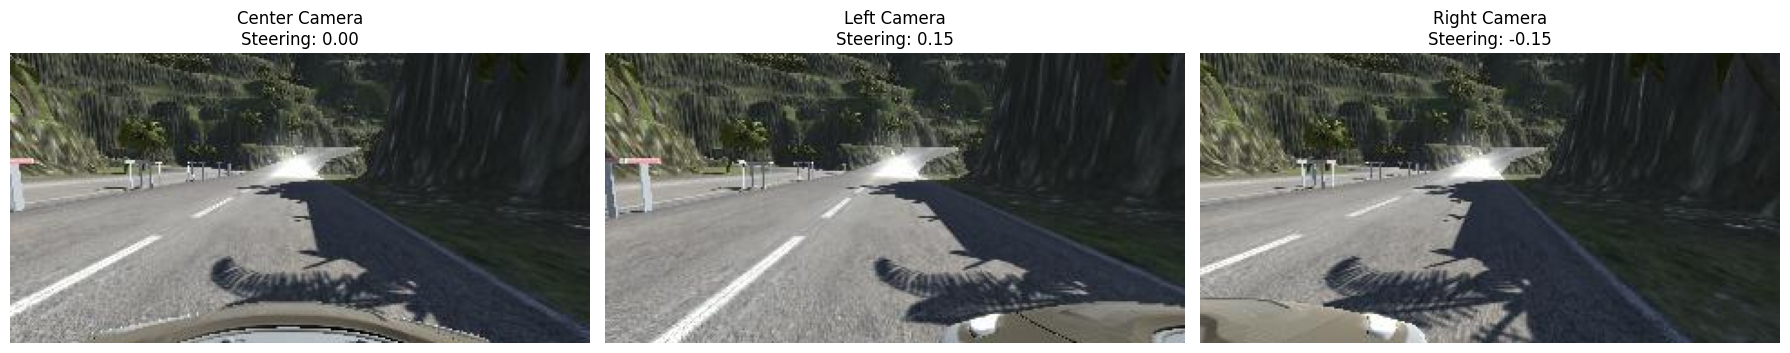

In [ ]:
sample_idx = 10
start_idx = sample_idx * 3

plt.figure(figsize=(18, 6))

camera_names = ['Center', 'Left', 'Right']

for i in range(3):
    img_path = image_paths[start_idx + i]
    steering_angle = steerings[start_idx + i]

    img = Image.open(img_path)

    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f'{camera_names[i]} Camera\nSteering: {steering_angle:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Split data: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Training samples: 52387
Validation samples: 13097


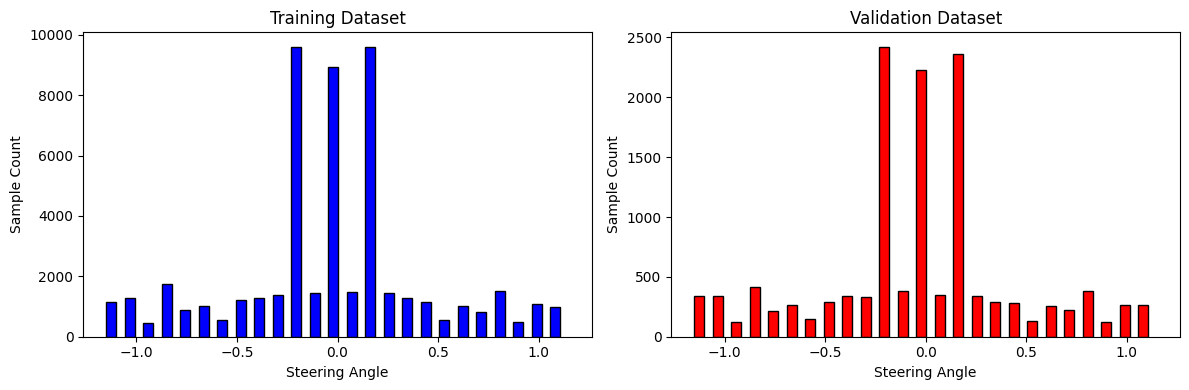

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Training distribution
axes[0].hist(y_train, bins=NUM_BINS, width=0.05, color='blue', edgecolor='black')
axes[0].set(title='Training Dataset', xlabel='Steering Angle', ylabel='Sample Count')

# Validation distribution
axes[1].hist(y_val, bins=NUM_BINS, width=0.05, color='red', edgecolor='black')
axes[1].set(title='Validation Dataset', xlabel='Steering Angle', ylabel='Sample Count')

plt.tight_layout()
plt.show()

## Data augmentation

---



### Data augmentation (Nvidia)

---



In [ ]:
def normalize_nvidia(image, **kwargs):
    """Normalize image to [0,1] as in NVIDIA PilotNet."""
    return image.astype(np.float32) / 255.0

import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


# Common transforms shared by train and val
common_transforms = [
    A.Crop(x_min=0, y_min=60, x_max=320, y_max=135, p=1.0),
    A.Lambda(image=lambda img, **kwargs: cv2.cvtColor(img, cv2.COLOR_RGB2YUV), p=1.0),
    A.GaussianBlur(blur_limit=3, p=1.0),
    A.Resize(height=66, width=200, interpolation=cv2.INTER_AREA, p=1.0),
    A.Lambda(image=normalize_nvidia, p=1.0),
    ToTensorV2(p=1.0),
]

def get_train_transforms():
    """NVIDIA-style augmentation pipeline for training."""
    return A.Compose([
        A.Affine(scale=(1.0, 1.4), mode=cv2.BORDER_REPLICATE, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.8, 0.2), contrast_limit=0, p=0.5),
        *common_transforms,
    ])

def get_val_transforms():
    """Validation preprocessing without augmentation."""
    return A.Compose(common_transforms)


# Dataset & DataLoader

---



In [ ]:
class DrivingDataset(Dataset):
    def __init__(self, image_paths, steerings, transform=None):
        self.image_paths = image_paths
        self.steerings = steerings
        self.transform = transform
        self.pan_correction = pan_correction

    def _random_flip(self, img, steering):
        if random.random() < 0.5:
            return cv2.flip(img, 1), -steering
        return img, steering


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        steering = self.steerings[idx]

        img = np.array(Image.open(img_path).convert('RGB'))

        img, steering = self._random_flip(img, steering)

        if self.transform:
            img = self.transform(image=img)['image']

        return img, torch.tensor(steering, dtype=torch.float32)


In [ ]:
# Create datasets
train_dataset = DrivingDataset(X_train, y_train, transform=get_train_transforms())
val_dataset = DrivingDataset(X_val, y_val, transform=get_val_transforms())

print(f"Training dataset: {len(train_dataset)} samples (with augmentation)")
print(f"Validation dataset: {len(val_dataset)} samples (no augmentation)")

batch_size = 64
print(f"Batch size: {batch_size}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
print(f"Train loader: {len(train_loader)} batches per epoch")

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)
print(f"Validation loader: {len(val_loader)} batches per epoch")

Training dataset: 52387 samples (with augmentation)
Validation dataset: 13097 samples (no augmentation)
Batch size: 64
Train loader: 819 batches per epoch
Validation loader: 205 batches per epoch


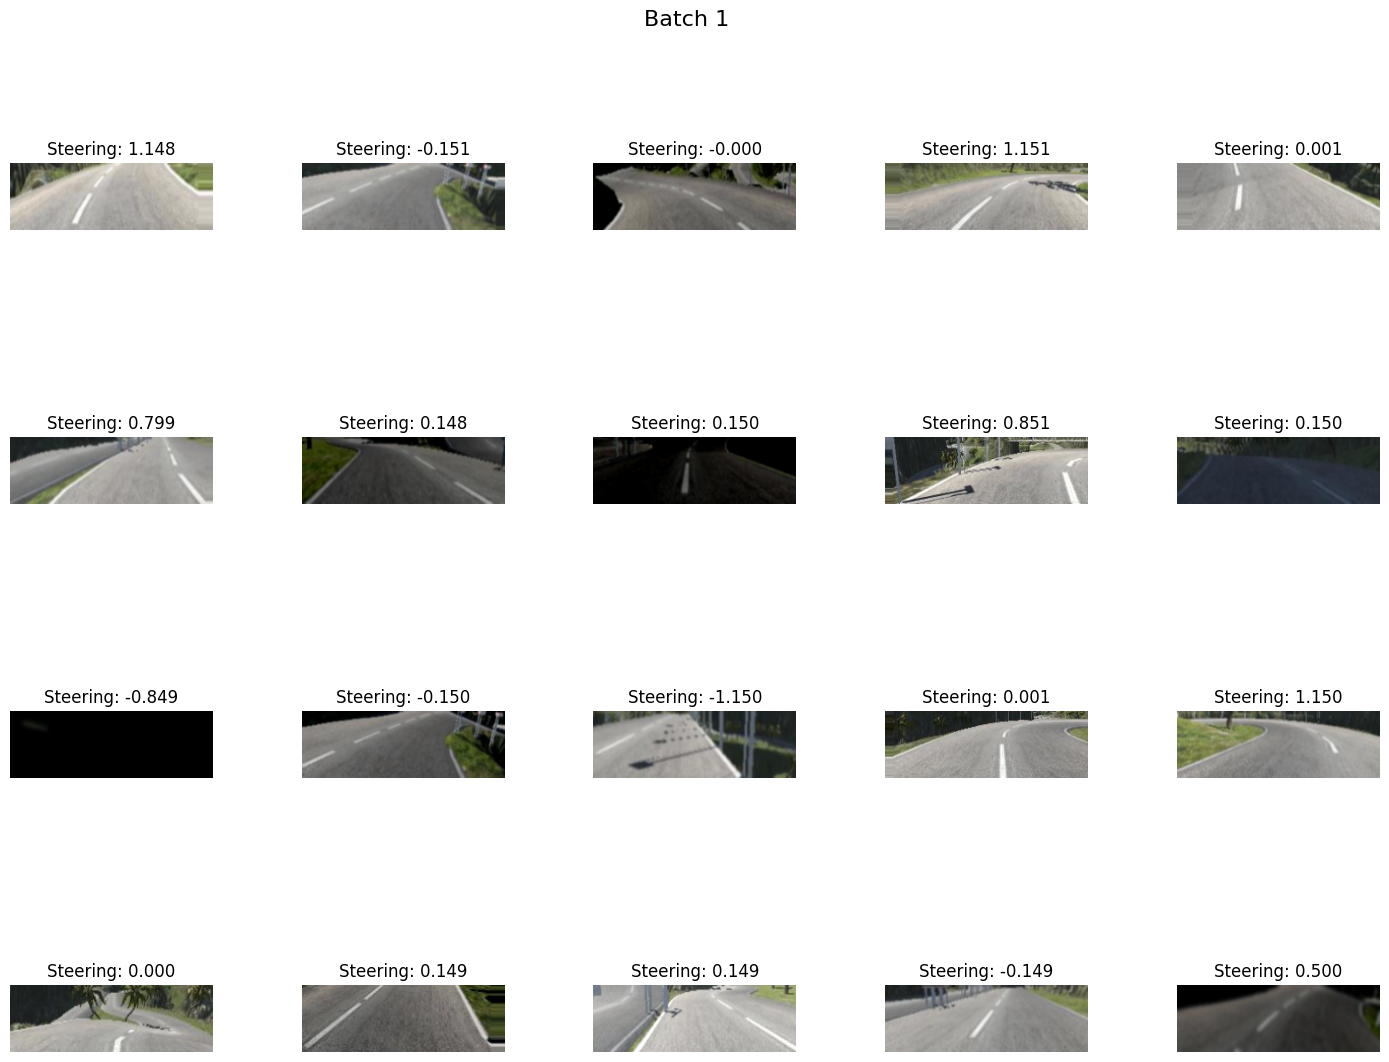

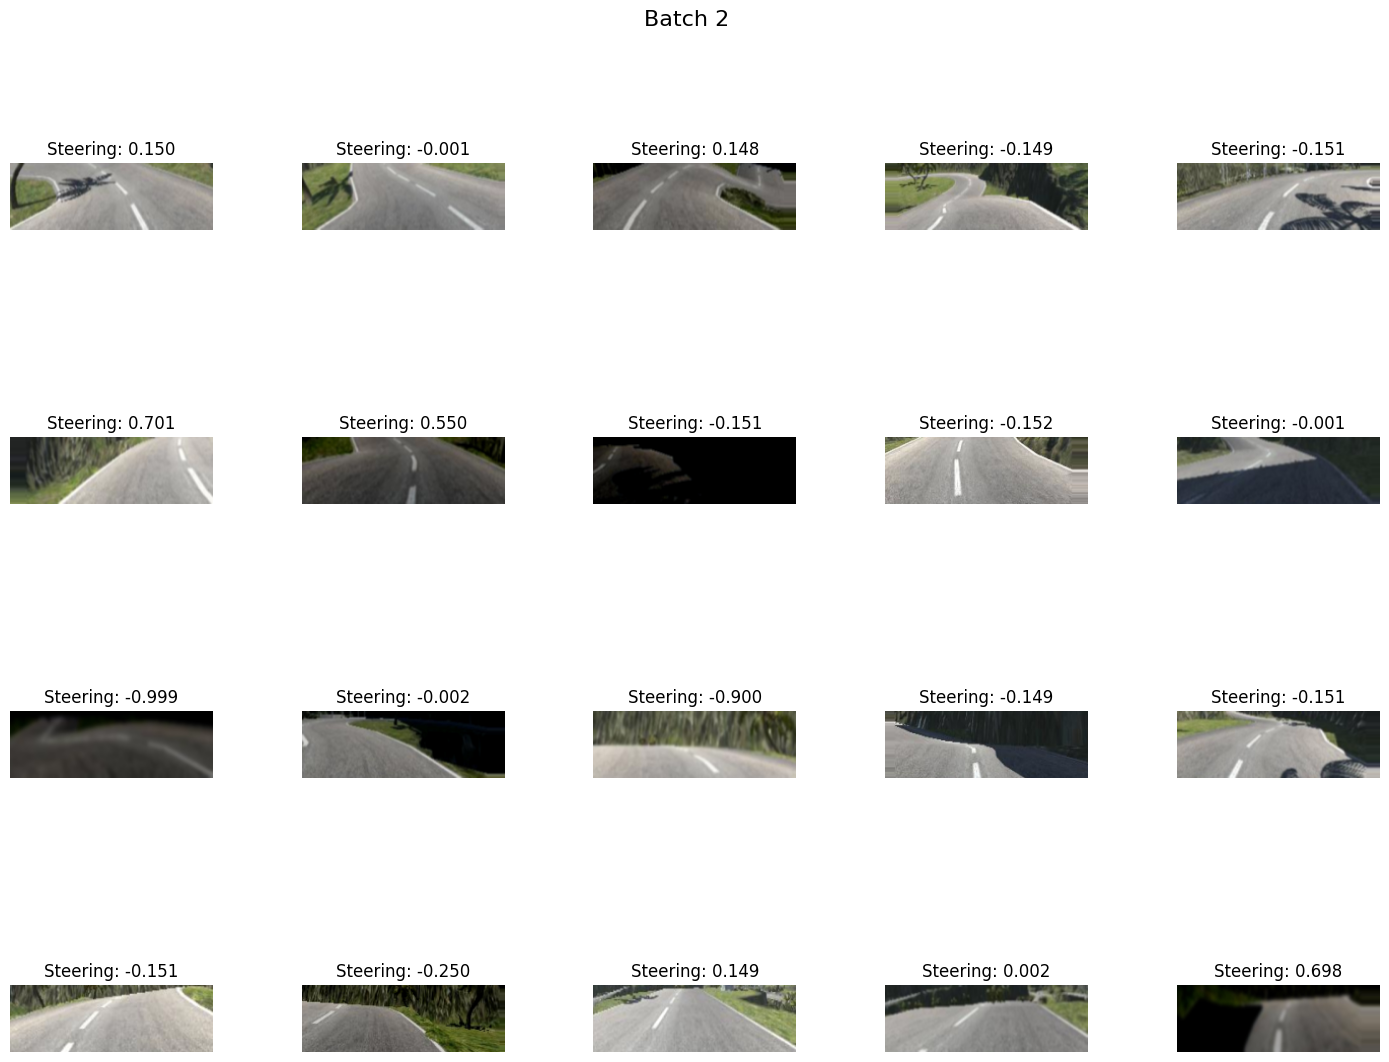

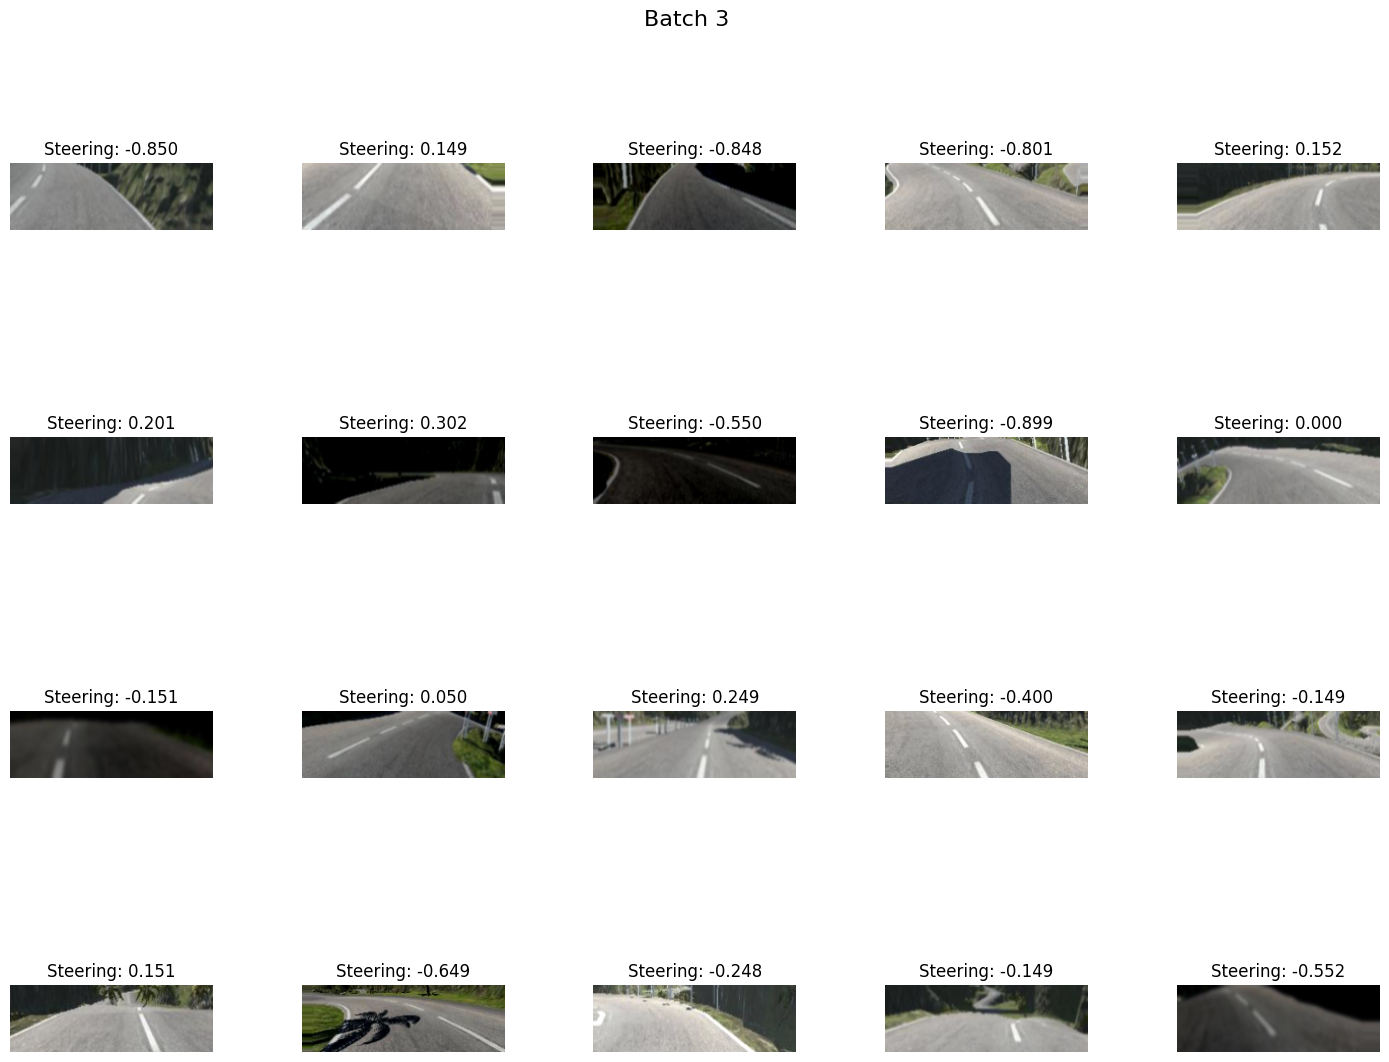

In [ ]:
num_batches = 3
images_per_batch = 20
cols = 5
rows = (images_per_batch + cols - 1) // cols

for batch_idx, (images, steerings) in enumerate(train_loader):
    if batch_idx >= num_batches:
        break

    batch_size = images.size(0)
    n_show = min(images_per_batch, batch_size)

    fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle(f'Batch {batch_idx + 1}', fontsize=16)
    fig.tight_layout(pad=3.0)

    for i in range(n_show):
        r, c = divmod(i, cols)
        img_yuv = images[i].permute(1, 2, 0).cpu().numpy()
        img_rgb = cv2.cvtColor((img_yuv * 255).astype(np.uint8), cv2.COLOR_YUV2RGB)

        axs[r, c].imshow(img_rgb)
        axs[r, c].set_title(f'Steering: {steerings[i].item():.3f}')
        axs[r, c].axis('off')

    # Remove unused subplots
    for j in range(n_show, rows * cols):
        r, c = divmod(j, cols)
        fig.delaxes(axs[r, c])

    plt.show()


# Modeling

---



## Model architecture (Nvidia)

---



In [ ]:
class NvidiaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ELU(),
            nn.Dropout(0.5)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 1 * 18, 100),
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.fc_layers(x)

print("NvidiaModel class defined.")

NvidiaModel class defined.


## Model Train (Nvidia)

---



In [ ]:
model = NvidiaModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model ready on {device}. Loss: MSE. Optimizer: Adam.")


Model ready on cuda. Loss: MSE. Optimizer: Adam.


In [ ]:
def train(model, loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, running_mae = 0.0, 0.0
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} Training", ncols=120)

    for i, (images, steerings) in pbar:
        images, steerings = images.to(device), steerings.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, steerings)
        loss.backward()
        optimizer.step()

        mae = F.l1_loss(outputs, steerings, reduction='mean').item()

        running_loss += loss.item()
        running_mae += mae

        pbar.set_postfix(loss=f"{running_loss/(i+1):.4f}", MAE=f"{running_mae/(i+1):.4f}")

    return running_loss / len(loader), running_mae / len(loader)

def validate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss, running_mae = 0.0, 0.0
    pbar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} Validation", ncols=120)

    with torch.no_grad():
        for i, (images, steerings) in pbar:
            images, steerings = images.to(device), steerings.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, steerings)
            mae = F.l1_loss(outputs, steerings, reduction='mean').item()

            running_loss += loss.item()
            running_mae += mae

            pbar.set_postfix(loss=f"{running_loss/(i+1):.4f}", MAE=f"{running_mae/(i+1):.4f}")

    return running_loss / len(loader), running_mae / len(loader)


In [ ]:
best_val_loss = float('inf')
num_epochs = 25

for epoch in range(num_epochs):
    train_loss, train_mae = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_mae = validate(model, val_loader, criterion, device, epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train: Loss={train_loss:.4f}, MAE={train_mae:.4f} | "
          f"Val: Loss={val_loss:.4f}, MAE={val_mae:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved best model at epoch {epoch+1} with val loss: {val_loss:.4f}")

print("Training complete.")


Epoch 0 Validation: 100%|████████████████████████████████████| 205/205 [00:23<00:00,  8.64it/s, MAE=0.3183, loss=0.1778]

Epoch 1/25 | Train: Loss=0.1946, MAE=0.3273 | Val: Loss=0.1778, MAE=0.3183
Saved best model at epoch 1 with val loss: 0.1778



Epoch 1 Validation: 100%|████████████████████████████████████| 205/205 [00:23<00:00,  8.74it/s, MAE=0.3134, loss=0.1664]

Epoch 2/25 | Train: Loss=0.1801, MAE=0.3182 | Val: Loss=0.1664, MAE=0.3134
Saved best model at epoch 2 with val loss: 0.1664



Epoch 2 Validation: 100%|████████████████████████████████████| 205/205 [00:23<00:00,  8.70it/s, MAE=0.3079, loss=0.1563]


Epoch 3/25 | Train: Loss=0.1726, MAE=0.3153 | Val: Loss=0.1563, MAE=0.3079
Saved best model at epoch 3 with val loss: 0.1563


Epoch 3 Validation: 100%|████████████████████████████████████| 205/205 [00:22<00:00,  9.00it/s, MAE=0.3136, loss=0.1551]

Epoch 4/25 | Train: Loss=0.1640, MAE=0.3105 | Val: Loss=0.1551, MAE=0.3136
Saved best model at epoch 4 with val loss: 0.1551



Epoch 4 Validation: 100%|████████████████████████████████████| 205/205 [00:24<00:00,  8.52it/s, MAE=0.3066, loss=0.1511]

Epoch 5/25 | Train: Loss=0.1596, MAE=0.3075 | Val: Loss=0.1511, MAE=0.3066
Saved best model at epoch 5 with val loss: 0.1511



Epoch 5 Validation: 100%|████████████████████████████████████| 205/205 [00:23<00:00,  8.76it/s, MAE=0.3035, loss=0.1486]

Epoch 6/25 | Train: Loss=0.1573, MAE=0.3065 | Val: Loss=0.1486, MAE=0.3035
Saved best model at epoch 6 with val loss: 0.1486



Epoch 6 Validation: 100%|████████████████████████████████████| 205/205 [00:26<00:00,  7.82it/s, MAE=0.3002, loss=0.1473]

Epoch 7/25 | Train: Loss=0.1554, MAE=0.3050 | Val: Loss=0.1473, MAE=0.3002
Saved best model at epoch 7 with val loss: 0.1473



Epoch 7 Validation: 100%|████████████████████████████████████| 205/205 [00:24<00:00,  8.54it/s, MAE=0.3013, loss=0.1487]

Epoch 8/25 | Train: Loss=0.1539, MAE=0.3033 | Val: Loss=0.1487, MAE=0.3013



Epoch 8 Validation: 100%|████████████████████████████████████| 205/205 [00:23<00:00,  8.55it/s, MAE=0.2953, loss=0.1425]

Epoch 9/25 | Train: Loss=0.1512, MAE=0.3014 | Val: Loss=0.1425, MAE=0.2953
Saved best model at epoch 9 with val loss: 0.1425



Epoch 9 Validation: 100%|████████████████████████████████████| 205/205 [00:23<00:00,  8.64it/s, MAE=0.2982, loss=0.1402]

Epoch 10/25 | Train: Loss=0.1493, MAE=0.3001 | Val: Loss=0.1402, MAE=0.2982
Saved best model at epoch 10 with val loss: 0.1402



Epoch 10 Validation: 100%|███████████████████████████████████| 205/205 [00:23<00:00,  8.56it/s, MAE=0.2931, loss=0.1392]

Epoch 11/25 | Train: Loss=0.1480, MAE=0.2987 | Val: Loss=0.1392, MAE=0.2931
Saved best model at epoch 11 with val loss: 0.1392



Epoch 11 Validation: 100%|███████████████████████████████████| 205/205 [00:22<00:00,  9.09it/s, MAE=0.2905, loss=0.1373]

Epoch 12/25 | Train: Loss=0.1466, MAE=0.2983 | Val: Loss=0.1373, MAE=0.2905
Saved best model at epoch 12 with val loss: 0.1373



Epoch 12 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.41it/s, MAE=0.2906, loss=0.1355]

Epoch 13/25 | Train: Loss=0.1447, MAE=0.2963 | Val: Loss=0.1355, MAE=0.2906
Saved best model at epoch 13 with val loss: 0.1355



Epoch 13 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.40it/s, MAE=0.2911, loss=0.1360]

Epoch 14/25 | Train: Loss=0.1432, MAE=0.2956 | Val: Loss=0.1360, MAE=0.2911



Epoch 14 Validation: 100%|███████████████████████████████████| 205/205 [00:22<00:00,  9.06it/s, MAE=0.2888, loss=0.1350]

Epoch 15/25 | Train: Loss=0.1418, MAE=0.2939 | Val: Loss=0.1350, MAE=0.2888
Saved best model at epoch 15 with val loss: 0.1350



Epoch 15 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.45it/s, MAE=0.2884, loss=0.1320]

Epoch 16/25 | Train: Loss=0.1396, MAE=0.2931 | Val: Loss=0.1320, MAE=0.2884
Saved best model at epoch 16 with val loss: 0.1320



Epoch 16 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.53it/s, MAE=0.2900, loss=0.1339]

Epoch 17/25 | Train: Loss=0.1391, MAE=0.2913 | Val: Loss=0.1339, MAE=0.2900



Epoch 17 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.51it/s, MAE=0.2853, loss=0.1315]

Epoch 18/25 | Train: Loss=0.1379, MAE=0.2910 | Val: Loss=0.1315, MAE=0.2853
Saved best model at epoch 18 with val loss: 0.1315



Epoch 18 Validation: 100%|███████████████████████████████████| 205/205 [00:22<00:00,  9.02it/s, MAE=0.2833, loss=0.1288]

Epoch 19/25 | Train: Loss=0.1372, MAE=0.2905 | Val: Loss=0.1288, MAE=0.2833
Saved best model at epoch 19 with val loss: 0.1288



Epoch 19 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.36it/s, MAE=0.2848, loss=0.1309]

Epoch 20/25 | Train: Loss=0.1360, MAE=0.2899 | Val: Loss=0.1309, MAE=0.2848



Epoch 20 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.34it/s, MAE=0.2841, loss=0.1301]

Epoch 21/25 | Train: Loss=0.1355, MAE=0.2886 | Val: Loss=0.1301, MAE=0.2841



Epoch 21 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.53it/s, MAE=0.2842, loss=0.1290]

Epoch 22/25 | Train: Loss=0.1345, MAE=0.2883 | Val: Loss=0.1290, MAE=0.2842



Epoch 22 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.44it/s, MAE=0.2829, loss=0.1301]

Epoch 23/25 | Train: Loss=0.1336, MAE=0.2869 | Val: Loss=0.1301, MAE=0.2829



Epoch 23 Validation: 100%|███████████████████████████████████| 205/205 [00:23<00:00,  8.72it/s, MAE=0.2836, loss=0.1295]

Epoch 24/25 | Train: Loss=0.1339, MAE=0.2873 | Val: Loss=0.1295, MAE=0.2836



Epoch 24 Validation: 100%|███████████████████████████████████| 205/205 [00:24<00:00,  8.54it/s, MAE=0.2822, loss=0.1276]


Epoch 25/25 | Train: Loss=0.1330, MAE=0.2865 | Val: Loss=0.1276, MAE=0.2822
Saved best model at epoch 25 with val loss: 0.1276
Training complete.


## Save model (Nvidia)

---



In [ ]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to: {path}")

In [ ]:
model_save_path = './nvidia_model.pth'
save_model(model, model_save_path)

Model saved to: ./nvidia_model.pth
